In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from scipy.stats import norm

## Preprocess the data

In [ ]:
data = pd.read_csv("data.csv", header=None)
data = data.to_numpy()

points, sigma, r = data[0,0].astype('int64'), data[0,1], data[0,2]

corrupted = True

y = data[1:,0]
X = data[1:,1]

#y = data["y"].to_numpy()
#data = data.drop(columns="y")
#X = data.to_numpy()
# print a few data samples
#print(data.head())

## L1 regression 
uses LP and solves $$min \sum_{j=1}^m z_j$$
such that for all j: $$ax_j+b-y_j \leq z_j \quad \text{and} \quad -ax_j-b+y_j \leq z_j$$ and $$z_j \geq 0$$

In [3]:
def L1(X,y):
    val = X.flatten()
    m = len(y)
    # Variables are: [a, b, slack_1, ..., slack_n]

    # Coefficients for the objective function
    c = np.zeros(m + 2)
    c[2:] = 1  # We want to minimize the sum of slack variables

    # Constraints matrix A_ub and vector b_ub for the inequalities A_ub @ x <= b_ub
    A_ub = np.zeros((2 * m, m + 2))
    b_ub = np.zeros(2 * m)

    for i in range(m):
        #ax_i
        A_ub[i, 0] = val[i]
        A_ub[m+i, 0] = -val[i]

        #b
        A_ub[i, 1] = 1
        A_ub[m+i, 1] = -1

        #z_i
        A_ub[i, i+2] = -1
        A_ub[m+i, i+2] = -1

        #y_i
        b_ub[i] = y[i]
        b_ub[m+i] = -y[i]

    # Bounds for the variables: a, b are unbounded, slack variables are >= 0
    bounds = [(None, None), (None, None)] + [(0, None)] * m

    # Solving the linear programming problem
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds)

    # Extracting the coefficients a and b
    a_1, b_1 = result.x[0], result.x[1]

    L1_train = result.fun/m
    #print(f"L1_train={L1_train}")
    #print(result.x[2:5])

    #print(f"a={a_1}, b={b_1}")

    return (a_1,b_1)

## L2 regression
Computes $$X^TXw = X^Ty$$, where $$w = (a,b)^T$$

In [4]:
def L2(X,y):
    X = X[:, np.newaxis]

    ones_column = np.ones((X.shape[0], 1))

    X = np.hstack((X, ones_column))

    XtX = np.matmul(X.T, X)
    print(XtX)
    # Compute X^T * y
    Xty = np.matmul(X.T, y)

    print(Xty)

    # Solve for w
    w = np.linalg.solve(XtX, Xty)

    a_2 = w[0]
    b_2 = w[1]

    #print(f"a={a_2}, b={b_2}")
    return (a_2,b_2)

## Main

In [ ]:

a_1,b_1 = L1(X,y)
a_2,b_2 = L2(X,y)
print("L1 coefficient: "+ str(a_1) + ", " + str(b_1) )
print("L2 coefficient: "+ str(a_2) + ", " + str(b_2))

[[10129.55844873   114.60443528]
 [  114.60443528 10000.        ]]
[  -52.36940443 -8980.        ]
L1 coefficient: -0.0, -1.0
L2 coefficient: 0.004990536692059975, -0.898057193763934


## Finding optimal t_1 and t_2 using linear search

In [81]:
def calculateEmpiricalError(results, t, y):
    results = np.array(results)
    hypothesis_results = np.sign(results-t)

    sum = 0.0
    for j in range(len(hypothesis_results)):
        if y[j] != hypothesis_results[j]:
            sum += 1.0

    return sum/len(hypothesis_results)


In [82]:
#calculate p_1,2(x^j) for all training point x
p_1_pairs = [(a_1 * x + b_1, y_val) for x, y_val in zip(X, y)]
p_2_pairs = [(a_2 * x + b_2, y_val) for x, y_val in zip(X, y)]

#sort lists
p_1_pairs_sorted = sorted(p_1_pairs, key=lambda pair: pair[0])
p_2_pairs_sorted = sorted(p_2_pairs, key=lambda pair: pair[0])

# Extract sorted p_1_results, p_2_results, and corresponding sorted y
p_1_results_sorted = [pair[0] for pair in p_1_pairs_sorted]
y_sorted_1 = [pair[1] for pair in p_1_pairs_sorted]

p_2_results_sorted = [pair[0] for pair in p_2_pairs_sorted]
y_sorted_2 = [pair[1] for pair in p_2_pairs_sorted]


#initialize optimal t and empirical error
t_1_opt = 0
t_2_opt = 0

curr_emp_err_1 = calculateEmpiricalError(p_1_results_sorted, t_1_opt, y_sorted_1)
curr_emp_err_2 = calculateEmpiricalError(p_2_results_sorted, t_2_opt, y_sorted_2)

#find t_1_opt by iterating through sorted p_1_results
for i in range(1, len(X)):
    left = max(-1.0, p_1_results_sorted[i-1])
    right = min(1.0, p_1_results_sorted[i])

    if left <= right:
        curr_t_1 = (right + left) / 2.0
        next_emp_err_1 = calculateEmpiricalError(p_1_results_sorted, curr_t_1, y_sorted_1)

        if next_emp_err_1 < curr_emp_err_1:
            t_1_opt = curr_t_1
            curr_emp_err_1 = next_emp_err_1

#find t_2_opt by iterating through sorted p_2_results
for i in range(1, len(X)):
    left = max(-1.0, p_2_results_sorted[i-1])
    right = min(1.0, p_2_results_sorted[i])

    if left <= right:
        curr_t_2 = (right + left) / 2.0
        next_emp_err_2 = calculateEmpiricalError(p_2_results_sorted, curr_t_2, y_sorted_2)

        if next_emp_err_2 < curr_emp_err_2:
            t_2_opt = curr_t_2
            curr_emp_err_2 = next_emp_err_2


## Print t_1,t_2 as well as L_1,L_2 and errors

### if L1 returns a constant polynomial, we calculate errors differently

In [83]:
L_1_error, L_2_error, actual_error = 0.0,0.0, 0.0

#calculate L1,L2 errors
for j in range(len(p_1_results_sorted)):
    L_1_error += abs(p_1_results_sorted[j]-y_sorted_1[j])
    L_2_error += (p_2_results_sorted[j]-y_sorted_2[j])**2
    actual_error += y_sorted_1[j]+1

L_1_error /= len(p_1_results_sorted)
L_2_error /= len(p_1_results_sorted)
actual_error /= len(p_1_results_sorted)

In [84]:
constantL1 = (a_1 == 0.0)
constantL1
#If the L1 polynomial is the constant p(x)=-1, corrupted must be true in this case
r_1 = 0.0
if not constantL1:
    r_1 = -(b_1-t_1_opt)/a_1
r_2 = -(b_2-t_2_opt)/a_2

#if corrupted:
err_1 = norm.cdf(r_1) - 0.5 + 1 - norm.cdf(r)
#err_2 = norm.cdf(r_2) - 0.5 + 1 - norm.cdf(r)
err_2 = norm.cdf(r)-0.5 + 1.0-norm.cdf(r_2)
if constantL1:
    err_1 = norm.cdf(r) - 0.5
#else:



In [85]:
print(f"r1={r_1}, r2={r_2}")
print(f"t1={t_1_opt}, t2={t_2_opt}")
#print(f"L1_train={L_1_error}, L2_train={L_2_error}, -1_error={actual_error}")
print(f"err1={err_1}, err2={err_2}")

r1=0.0, r2=179.95202704205295
t1=0, t2=0
err1=0.050000000000000044, err2=0.050000000000000044


## Plotting both results as well as the data distribution

0.0


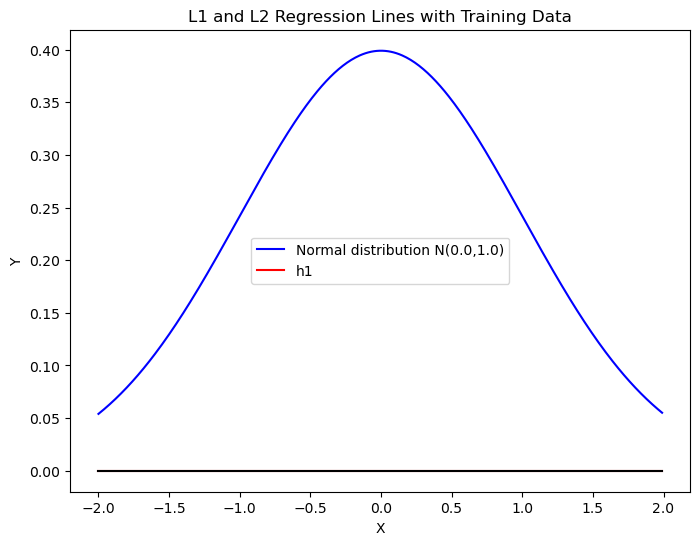

In [24]:
x = np.arange(-2.0,2.0,0.01)

p = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)
y_1 = a_1 * x + b_1
y_2 = a_2 * x + b_2

h_1 = np.sign(a_1 * x + b_1-t_1_opt)
h_2 = np.sign(a_2 * x + b_2-t_2_opt)

print(b_1-t_1_opt)

plt.figure(figsize=(8, 6))
plt.plot(x, p, color="blue", label="Normal distribution N(0.0,"+str(sigma) +")")
#plt.plot(x, y_1, color='red', label='L1: a=' + str(a_1) + " b="+ str(b_1))
#plt.plot(x, y_2, color='green', label='L2 a=' + str(a_2) + " b="+ str(b_2))
#plt.plot(x, np.sign(x), color = "purple", label="sgn(x)")

plt.plot(x, h_1, color = "red", label="h1")
#plt.plot(x, h_2, color = "green", label="h2")

plt.plot(x, np.zeros(x.shape), color="black")



plt.xlabel('X')
plt.ylabel('Y')
plt.title('L1 and L2 Regression Lines with Training Data')
plt.legend()

plt.show()